### Import packages

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import math 
from scipy.optimize import minimize


# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Preprocessing 
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# machine learning
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, learning_curve, validation_curve

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

## Part A

### Predict propensity to pay renewal premium

### Functions

In [2]:
# Create table for missing data analysis
def missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

### Read and Understand the data

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv') 
test_eid = test_df['employee_id']

train_len = len(train_df)
dataset =  pd.concat(objs=[train_df, test_df], axis=0, sort=False).reset_index(drop=True)


In [4]:
train_df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [5]:
train_df.describe(include=['O'])

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
employee_id             54808 non-null int64
department              54808 non-null object
region                  54808 non-null object
education               52399 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null float64
length_of_service       54808 non-null int64
KPIs_met >80%           54808 non-null int64
awards_won?             54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [7]:
test_df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [8]:
test_df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
count,23490.000000,23490.000000,23490.000000,21678.000000,23490.000000,23490.000000,23490.000000,23490.000000
mean,39041.399149,1.254236,34.782929,3.339146,5.810387,0.358834,0.022776,63.263133
std,22640.809201,0.600910,7.679492,1.263294,4.207917,0.479668,0.149191,13.411750
min,3.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000
25%,19370.250000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000
50%,38963.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000
75%,58690.000000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000
max,78295.000000,9.000000,60.000000,5.000000,34.000000,1.000000,1.000000,99.000000


In [9]:
test_df.describe(include=['O'])

,department,region,education,gender,recruitment_channel
count,23490,23490,22456,23490,23490
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,7315,5299,15578,16596,13078


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
employee_id             23490 non-null int64
department              23490 non-null object
region                  23490 non-null object
education               22456 non-null object
gender                  23490 non-null object
recruitment_channel     23490 non-null object
no_of_trainings         23490 non-null int64
age                     23490 non-null int64
previous_year_rating    21678 non-null float64
length_of_service       23490 non-null int64
KPIs_met >80%           23490 non-null int64
awards_won?             23490 non-null int64
avg_training_score      23490 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 2.3+ MB


### EDA

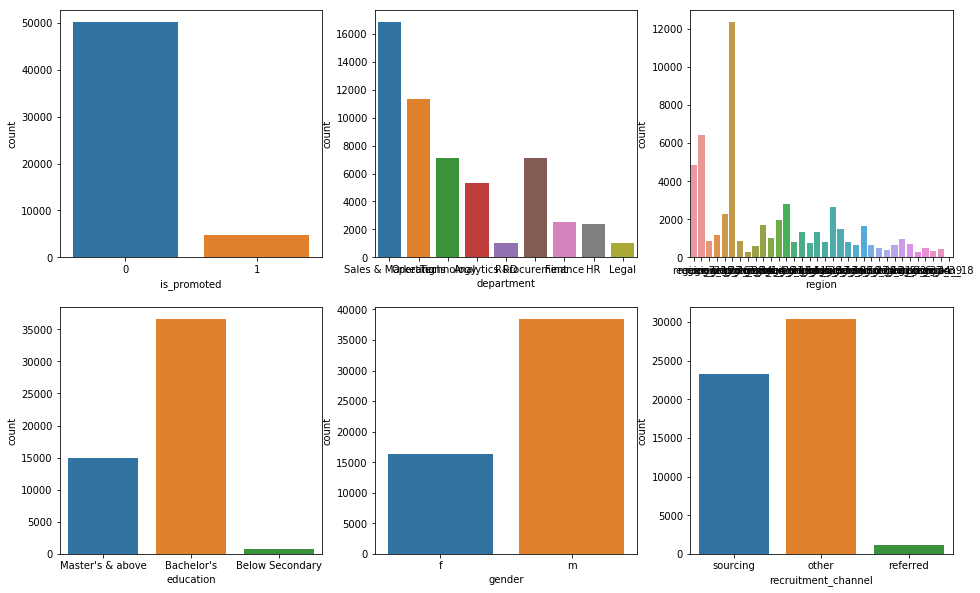

In [11]:
# Get the count of each categorical variables and target variable

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

sns.countplot('is_promoted',data=train_df,ax=axes[0,0])
sns.countplot('department',data=train_df,ax=axes[0,1])
sns.countplot('region',data=train_df,ax=axes[0,2])
sns.countplot('education',data=train_df,ax=axes[1,0])
sns.countplot('gender',data=train_df,ax=axes[1,1])
sns.countplot('recruitment_channel',data=train_df,ax=axes[1,2])

C:\Users\ashish\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\ashish\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\ashish\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\ashish\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\ashish\Anaconda3\lib\site-packages\matplotlib\axes\_axe

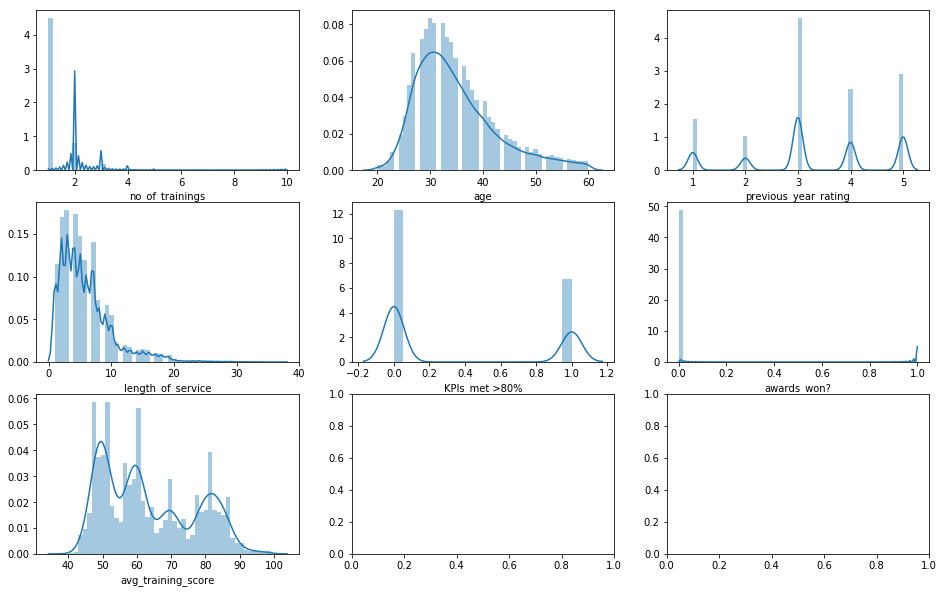

In [12]:
# Trying to understand the distribution of each numeric variables

fig, axes = plt.subplots(3, 3, figsize=(16, 10))

sns.distplot(train_df['no_of_trainings'], kde=True,ax=axes[0,0])
sns.distplot(train_df['age'].dropna(),kde=True,ax=axes[0,1])
sns.distplot(train_df['previous_year_rating'].dropna(),kde=True,ax=axes[0,2])
sns.distplot(train_df['length_of_service'].dropna(),kde=True,ax=axes[1,0])
sns.distplot(train_df['KPIs_met >80%'].dropna(),kde=True,ax=axes[1,1])
sns.distplot(train_df['awards_won?'].dropna(),kde=True,ax=axes[1,2])
sns.distplot(train_df['avg_training_score'].dropna(),kde=True,ax=axes[2,0]) 

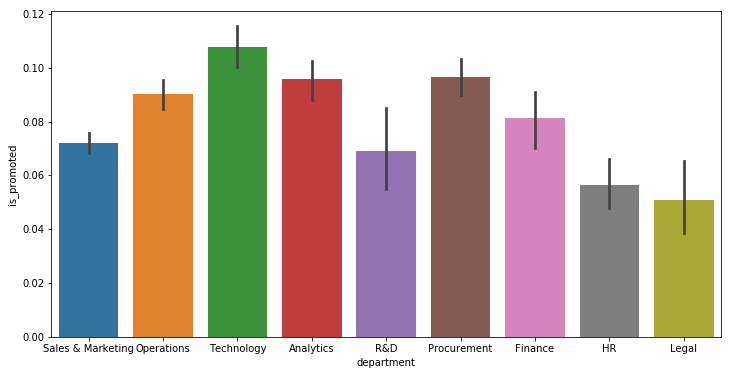

In [13]:
# Trying to understand how categorical features are related to target variable

f, ax = plt.subplots(figsize=(12, 6))
fig = sns.barplot(train_df['department'],train_df['is_promoted']);

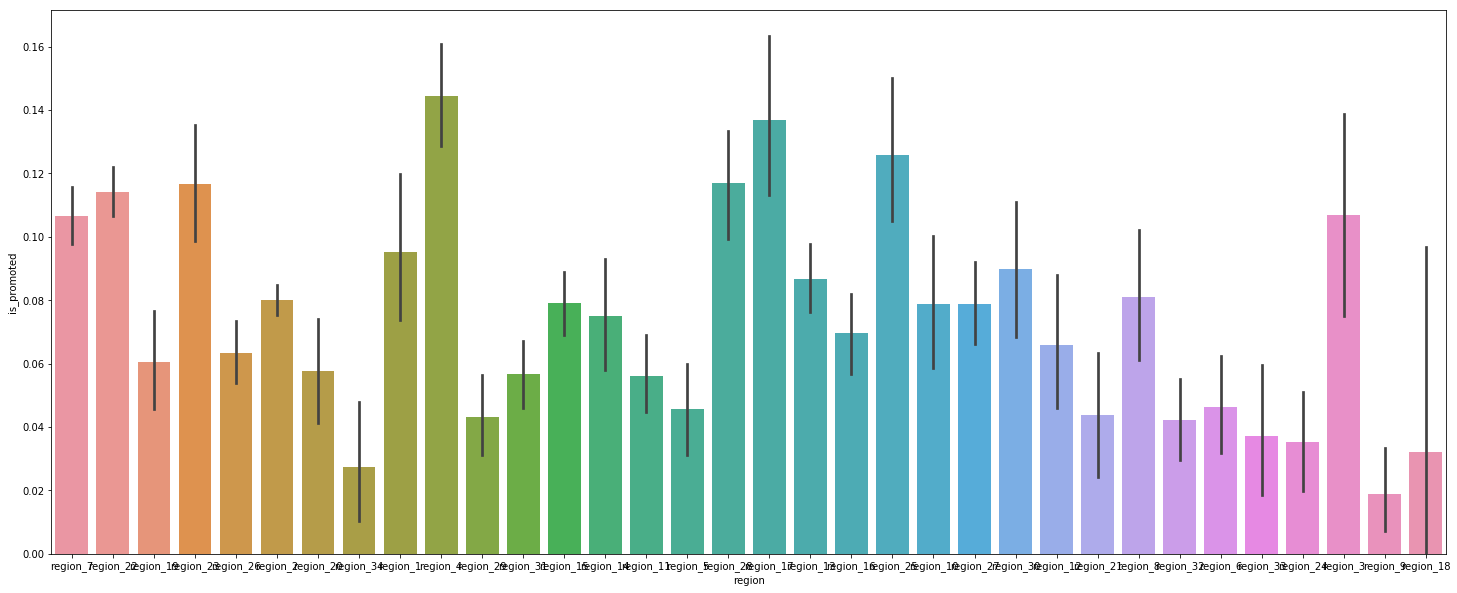

In [14]:
f, ax = plt.subplots(figsize=(25, 10))
fig = sns.barplot(train_df['region'],train_df['is_promoted']);

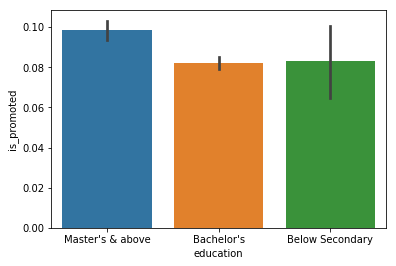

In [15]:
sns.barplot(train_df['education'],train_df['is_promoted']);

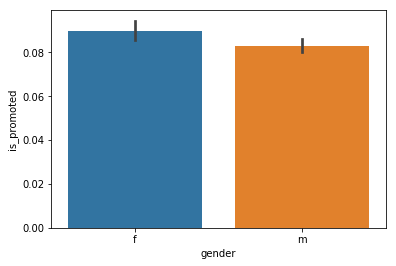

In [16]:
sns.barplot(train_df['gender'],train_df['is_promoted']);

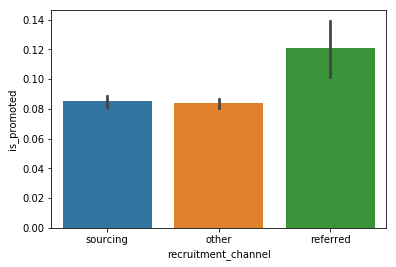

In [17]:
sns.barplot(train_df['recruitment_channel'],train_df['is_promoted']);

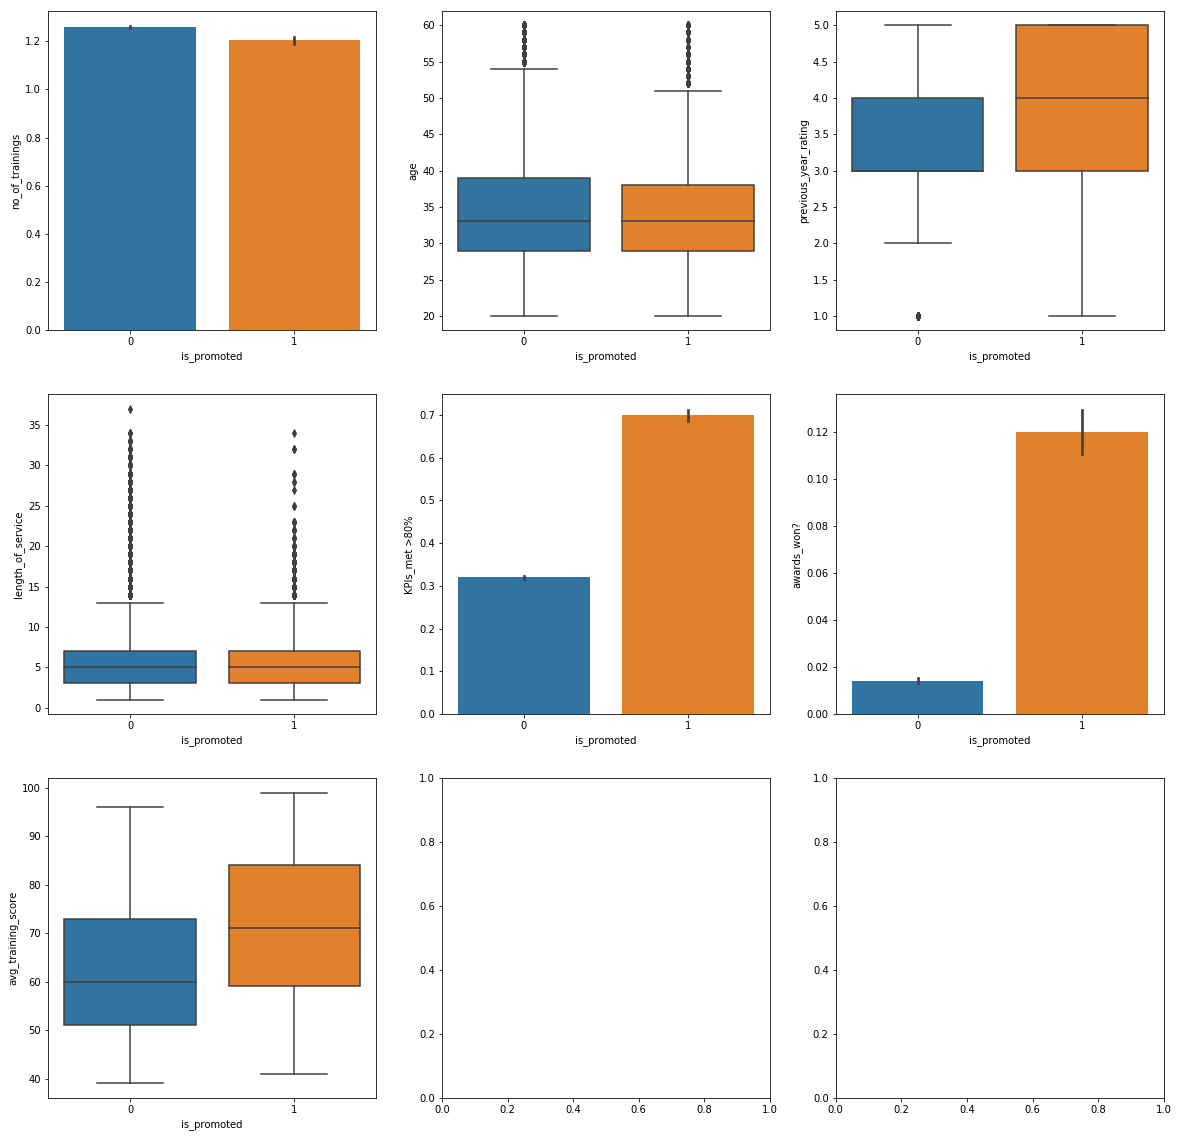

In [18]:
# Trying to understand how numerical features are related to target variable


figbi, axesbi = plt.subplots(3, 3, figsize=(20, 20))
sns.barplot(x="is_promoted", y="no_of_trainings", data=train_df,ax=axesbi[0,0])
sns.boxplot(x="is_promoted", y="age", data=train_df,ax=axesbi[0,1])
sns.boxplot(x="is_promoted", y="previous_year_rating", data=train_df,ax=axesbi[0,2])
sns.boxplot(x="is_promoted", y="length_of_service", data=train_df,ax=axesbi[1,0])
sns.barplot(x="is_promoted", y="KPIs_met >80%", data=train_df,ax=axesbi[1,1])
sns.barplot(x="is_promoted", y="awards_won?", data=train_df,ax=axesbi[1,2])
sns.boxplot(x="is_promoted", y="avg_training_score", data=train_df,ax=axesbi[2,0])

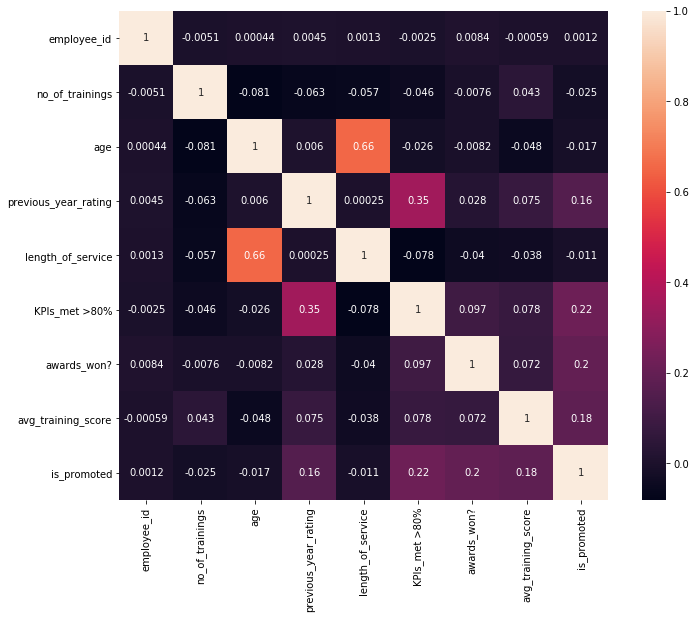

In [19]:
# Trying to understand overall numerical feature correlation
#correlation matrix

corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1.0, square=True, annot=True);

### Look for missing values and filling them

In [20]:
missing_data_table(dataset)

,Total,Percent
is_promoted,23490,0.300008
previous_year_rating,5936,0.075813
education,3443,0.043973
avg_training_score,0,0.000000
awards_won?,0,0.000000
KPIs_met >80%,0,0.000000
length_of_service,0,0.000000
age,0,0.000000
no_of_trainings,0,0.000000
recruitment_channel,0,0.000000


In [21]:
#train_df['previous_year_rating'].unique()
#train_df['education'].unique()

In [22]:
# Filling missing values for 'education' and previous_year_rating feature 

dataset['education'] = dataset['education'].fillna(dataset['education'].value_counts().index[0])

dataset['previous_year_rating'] = dataset['previous_year_rating'].fillna(dataset['previous_year_rating'].value_counts().index[0])


In [23]:
missing_data_table(dataset)

,Total,Percent
is_promoted,23490,0.300008
avg_training_score,0,0.000000
awards_won?,0,0.000000
KPIs_met >80%,0,0.000000
length_of_service,0,0.000000
previous_year_rating,0,0.000000
age,0,0.000000
no_of_trainings,0,0.000000
recruitment_channel,0,0.000000
gender,0,0.000000


### Prepare Data

In [24]:
# Dropping employee_id and categorical features like region and gender

dataset.drop('employee_id', axis=1, inplace=True)
dataset.drop('region', axis=1, inplace=True)
dataset.head()

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0.0
1,Operations,Bachelor's,m,other,1,30,5.0,4,0,0,60,0.0
2,Sales & Marketing,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0.0
3,Sales & Marketing,Bachelor's,m,other,2,39,1.0,10,0,0,50,0.0
4,Technology,Bachelor's,m,other,1,45,3.0,2,0,0,73,0.0


In [25]:
dataset = pd.get_dummies(dataset, columns = ["department"], prefix="dep", drop_first=True)

In [26]:
dataset = pd.get_dummies(dataset, columns = ["education"], prefix="ed", drop_first=True)

In [27]:
dataset = pd.get_dummies(dataset, columns = ["gender"], prefix="ed", drop_first=True)

In [28]:
dataset = pd.get_dummies(dataset, columns = ["recruitment_channel"], prefix="rc", drop_first=True)

In [29]:
dataset.head()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,dep_Finance,dep_HR,...,dep_Operations,dep_Procurement,dep_R&D,dep_Sales & Marketing,dep_Technology,ed_Below Secondary,ed_Master's & above,ed_m,rc_referred,rc_sourcing
0,1,35,5.0,8,1,0,49,0.0,0,0,...,0,0,0,1,0,0,1,0,0,1
1,1,30,5.0,4,0,0,60,0.0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1,34,3.0,7,0,0,50,0.0,0,0,...,0,0,0,1,0,0,0,1,0,1
3,2,39,1.0,10,0,0,50,0.0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,1,45,3.0,2,0,0,73,0.0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [30]:
# Separate  train and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["is_promoted"],axis = 1,inplace=True)

# Separate train features and label. Then Split the training data
X_train = train.drop(labels = ['is_promoted'],axis = 1)
y_train = train['is_promoted'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=1)

C:\Users\ashish\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [31]:
#Feature Scaling
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
# Modelling

In [33]:
kfold = StratifiedKFold(n_splits=10)

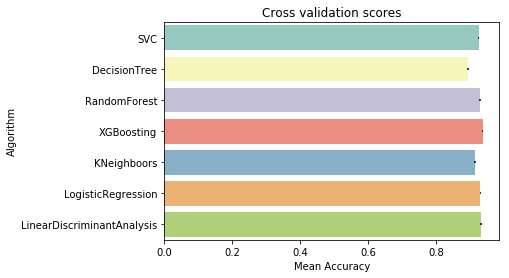

In [34]:
# Lets test various classifiers

random_state = 1
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(XGBClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())



cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "f1_micro", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","RandomForest","XGBoosting","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

## Hyperparameter Tunning for Best Classifiers

In [35]:
# RF Classifier Parameters tunning 
#RFC = RandomForestClassifier()


## Search grid for optimal parameters
#rf_param_grid = {"max_depth": [None],
#              "max_features": [1, 3, 10],
#              "min_samples_split": [2, 3, 10],
#              "min_samples_leaf": [1, 3, 10],
#              "bootstrap": [False],
#              "n_estimators" :[100,300],
#              "criterion": ["gini"]}


#gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="f1_micro", n_jobs= 4, verbose = 1)

#gsRFC.fit(X_train,y_train)

#RFC_best = gsRFC.best_estimator_

# Best score
#gsRFC.best_score_

In [ ]:
# Gradient boosting tunning

GBC = XGBClassifier()
gb_param_grid = {'max_depth': (5, 10),
                  'learning_rate': (0.01, 0.3),
                  'n_estimators': (50, 1000),
                  'gamma': (1., 0.01),
                  'min_child_weight': (2, 10),
                  'max_delta_step': (0, 0.1),
                  'subsample': (0.7, 0.8),
                  'colsample_bytree' :(0.5, 0.99)
                  } 
            
gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="f1_micro", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
#gsGBC.best_score_

Fitting 10 folds for each of 256 candidates, totalling 2560 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.1min


In [ ]:
### SVC classifier
#SVMC = SVC(probability=True)
#svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

#gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="f1_micro", n_jobs= 4, verbose = 1)

#gsSVMC.fit(X_train,y_train)

#SVMC_best = gsSVMC.best_estimator_

# Best score
#gsSVMC.best_score_

In [ ]:
#test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
#test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
#test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

## Combining Models

In [ ]:
#votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('svc', SVMC_best), ('gbc',GBC_best)], voting='soft', n_jobs=4)
#votingC = votingC.fit(X_train, Y_train)

### Prediction

In [ ]:
#Prediction

X_test_final= scaler.fit_transform(test)
ypred = GBC_best.predict(X_test_final)

In [ ]:
#ypred

In [ ]:

submission = pd.DataFrame({ 'employee_id': test_eid,
                            'is_promoted': ypred})

In [ ]:

submission.to_csv("submission.csv", index=False)